# Parameter tuning

This script is to tune the parameters of a model and test different parameters.

To test different models and types (BERT, GPT2, XLNet, ...) it can be changed in the MultiLabelClassificationModel function as descibed in the [Simple transformers docs](https://simpletransformers.ai/docs/installation/). 

### SDG classifier

In [1]:
# define imports
import wandb
import torch
import sklearn
import itertools
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections.abc
#hyper needs the four following aliases to be done manually.
# this makes it so that simple transformers work 
# with python 3.10 (only for specific environemnts such as Hipergator)
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

/blue/hulcr/gmarais/conda/envs/NLP/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()
print(cuda_available, torch.cuda.get_device_name(0))

True NVIDIA A100-SXM4-80GB


% PER CLASS:

 SDG1      4.686959
SDG2      2.662763
SDG3      6.276512
SDG4      7.476519
SDG5     15.678534
SDG6      1.347068
SDG7      0.315688
SDG8     10.896150
SDG9      0.552291
SDG10    10.155622
SDG11     2.888254
SDG12     0.971902
SDG13     0.998699
SDG14     0.289544
SDG15     0.369937
SDG16    28.666200
SDG17     5.767358
dtype: float64

class weight:  [1.2550468799986876, 2.2091166363452595, 0.9372009972373829, 0.7867769190025866, 0.375185141590403, 4.3667836858178495, 18.633418584825233, 0.5398561080001553, 10.650817960320222, 0.5792213397136432, 2.036646566297938, 6.05241504806361, 5.89001385894672, 20.315894303545345, 15.900956142174184, 0.20520169580862738, 1.0199389365900486]


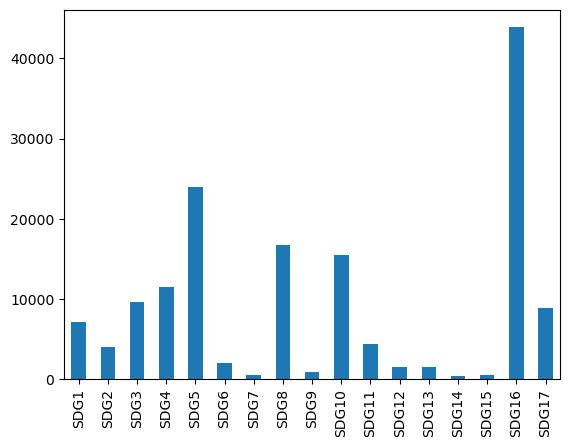

In [3]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data[data['source']!='SASDG_Hub'] #keep the articles classified by Willem separate as an unseen testing set
# data = data.iloc[-1000:,:] # select a small subset of the data (last 1000 rows)

# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)
eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

print("\nclass weight: ",list((1/label_count)/class_weight))

In [4]:
# create function for creating layer learning rate dictionary
# this is used for freezing the number of layers from the first layer -> x layer
def create_custom_layer_dict_lst(x):    
    # get list of number of layers
    # layers_lst = [0]
    # for i in model.get_named_parameters():
    #     layers_lst.append(int(re.findall(r"layer\.(\d+)", i)[0]))
    #     layers_lst = list(set(layers_lst))
    # create dictionary of 
    layer_dict_lst = []
    for i in range(x+1):
        layer_dict_lst.append({'layer':i, 'lr':0.0})
    return layer_dict_lst

# Define the sweep config. 
# this defines the parameters that will be searched when performing parameter optimisation
sweep_config = {
    "method": "bayes",  # bayes, grid, random
    "metric": {"name": "f1_macro", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"value":5},#{"min": 1, "max": 50},
        "learning_rate": {"min": 0.0001, "max": 0.1},
        "train_batch_size":{"min": 1, "max": 500},
        "eval_batch_size":{"min": 1, "max": 500},
        "warmup_steps":{"min": 50, "max": 250},
        "weight_decay":{"min": 0.0001, "max": 0.1},
        # "logging_steps":{"min": 1, "max": 20}, #{"values": [2, 5, 10]}
        "threshold":{"min":0.0, "max":1.0},
        'custom_layer_parameters':{"values": [create_custom_layer_dict_lst(0),
                                              create_custom_layer_dict_lst(1),
                                              create_custom_layer_dict_lst(2),
                                              create_custom_layer_dict_lst(3),
                                              create_custom_layer_dict_lst(4),
                                              create_custom_layer_dict_lst(5),
                                              create_custom_layer_dict_lst(6), 
                                              create_custom_layer_dict_lst(7),
                                              create_custom_layer_dict_lst(8),
                                              create_custom_layer_dict_lst(9),
                                              create_custom_layer_dict_lst(10),
                                              create_custom_layer_dict_lst(11),
                                              create_custom_layer_dict_lst(12)]}
    },
}

# define the project and entity under which the outputs will be recorded in wandb
sweep_id = wandb.sweep(sweep_config, entity='christopher-marais', project="sasdghub_param_tuning")

# Set logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: t2nv63bn
Sweep URL: https://wandb.ai/christopher-marais/sasdghub_param_tuning/sweeps/t2nv63bn


In [5]:
# create functions for additional evaluation outputs
def acc_result(true, pred):
    pred=(pred>=wandb.config['threshold']).astype(int)
    acc_sum = 0
    for i in range(true.shape[0]):
        acc_sum += sklearn.metrics.accuracy_score(true[i], pred[i])    
    acc = acc_sum/true.shape[0]
    return acc

def f1_macro_result(true, pred):
    pred=(pred>=wandb.config['threshold']).astype(int)
    f1 = sklearn.metrics.f1_score(true, pred, average='samples')
    return f1

def cm_wandb_result(true, pred):
    pred=(pred>=wandb.config['threshold']).astype(int)
    # modify labels and fill all combinations to use wand multiclass confusion matrix visually
    d=true-pred
    t_d = (d==1)
    p_d = (d==-1)
    n_d = (d==0)
    idx_ar = np.array(range(0,true.shape[1]))
    idx = np.tile(idx_ar,true.shape[0]).reshape(true.shape[0],true.shape[1])
    n_labels = idx[n_d]
    t_lst = []
    for row in t_d:
        if row.sum()==0:
            t_lst.append(idx_ar)
        else:
            t_lst.append(idx_ar[row])
    p_lst = []
    for row in p_d:
        if row.sum()==0:
            p_lst.append(idx_ar)
        else:
            p_lst.append(idx_ar[row])
    for i in range(len(t_lst)):
        fill_ar = np.array(list(itertools.product(p_lst[i], t_lst[i])))
        t_labels = np.append(n_labels,fill_ar[:,0].tolist())
        p_labels = np.append(n_labels,fill_ar[:,1].tolist())
    wandb_cm = wandb.plot.confusion_matrix(probs=None, y_true=t_labels, preds=p_labels, class_names=sdg_lst)
    return wandb_cm

def cm_result(true, pred):
    pred=(pred>=wandb.config['threshold']).astype(int)
    cm = sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

def cm_avg_result(true, pred):
    pred=(pred>=wandb.config['threshold']).astype(int)
    cm = sklearn.metrics.multilabel_confusion_matrix(true, pred)
    cm_avg = cm.sum(axis=0)/true.shape[1]
    return cm_avg

In [ ]:
# Optional model configuration
model_args = MultiLabelClassificationArgs(fp16= False,
                                          manual_seed = 4,
                                          use_multiprocessing = True,
                                          overwrite_output_dir=True,
                                          evaluate_during_training = True,
                                          # save_steps=-1, # use this parameter and the next parameter to train on text of longer than 512 words in length
                                          # sliding_window=True, # these parameters are bugged in this current version and will likely be updated soon
                                         )

# define the training function
def train():
    
    # Initialize a new wandb run 
    wandb.init()

    # Create a MultiLabelClassificationModel
    model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list((1/label_count)/class_weight),
        # show_running_loss=True,
        sweep_config=wandb.config,
    )
            
    # Train the model
    model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1_macro=f1_macro_result,
                      cm=cm_result,
                      cm_avg=cm_avg_result,
                      wandb_cm=cm_wandb_result
                     )
    
    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(
        verbose=True,
        eval_df=eval_df,
        accuracy=acc_result,
        f1_macro=f1_macro_result,
        cm=cm_result,
        cm_avg=cm_avg_result,
        wandb_cm=cm_wandb_result
        )
    
    # Sync wandb
    wandb.join()

# run the sweep and record results in wandb    
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: b4vm0hir with config:
wandb: 	custom_layer_parameters: [{'layer': 0, 'lr': 0}, {'layer': 1, 'lr': 0}, {'layer': 2, 'lr': 0}, {'layer': 3, 'lr': 0}, {'layer': 4, 'lr': 0}, {'layer': 5, 'lr': 0}, {'layer': 6, 'lr': 0}]
wandb: 	eval_batch_size: 405
wandb: 	learning_rate: 0.08865235621898625
wandb: 	num_train_epochs: 5
wandb: 	threshold: 0.8052814882244453
wandb: 	train_batch_size: 427
wandb: 	warmup_steps: 229
wandb: 	weight_decay: 0.05885041926383702
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christopher-marais. Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/63782 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_0_2
/blue/hulcr/gmarais/conda/envs/NLP/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/150 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/27336 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 1 of 5:   0%|          | 0/150 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/27336 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_0_2


Running Epoch 2 of 5:   0%|          | 0/150 [00:00<?, ?it/s]